In [1]:
%matplotlib inline

import sys

sys.path.append("..")

In [2]:
import torch
torch.cuda._lazy_init() # avoid "Unknown CUDA error"
torch.cuda.is_available()

True

In [3]:
# Load the Dataset class
from torchvision import transforms

from settings import DATA_SOURCES
from src.datasets.sketchy import Sketchy

# dataset = Sketchy(DATA_SOURCES['sketchy_test']['photos'], transforms.Grayscale(num_output_channels=1))
dataset = Sketchy(DATA_SOURCES['sketchy_test']['photos'])
len(dataset)

1250

In [15]:
# from torchvision.datasets import ImageFolder

# # load with a grayscale transform
# dataset = ImageFolder(
#     root=DATA_SOURCES['sketchy_test']['photos'],
#     transform=transforms.Compose([
#         transforms.Resize(DATA_SOURCES['sketchy']['dimensions'][0]),
#         transforms.CenterCrop(DATA_SOURCES['sketchy']['dimensions'][0]),
#         transforms.Grayscale(num_output_channels=1),
#         transforms.ToTensor(),
# #         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     ])
# )

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torchvision.utils as vutils

# # Plot some training images
# image = dataset[0]
# plt.figure(figsize=(4,4))
# plt.axis("off")
# plt.title("Class: %s" % image[1])
# plt.imshow(np.transpose(vutils.make_grid(image[0].to(device), padding=2, normalize=True).cpu(), (1,2,0)))

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Number of workers for dataloader
workers = 8

# Batch size for dataloader
batch_size = 1

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

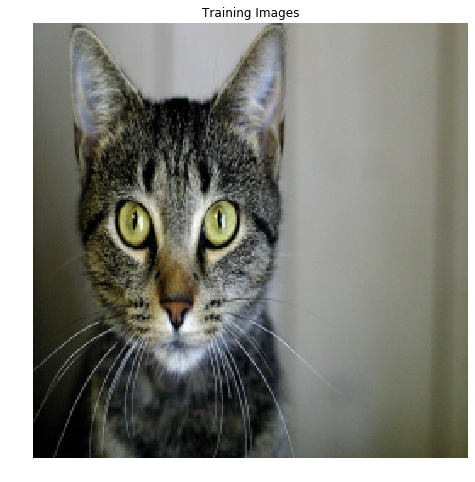

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Create the dataloader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
inputs, labels = next(iter(data_loader))
inputs.shape

torch.Size([1, 3, 256, 256])

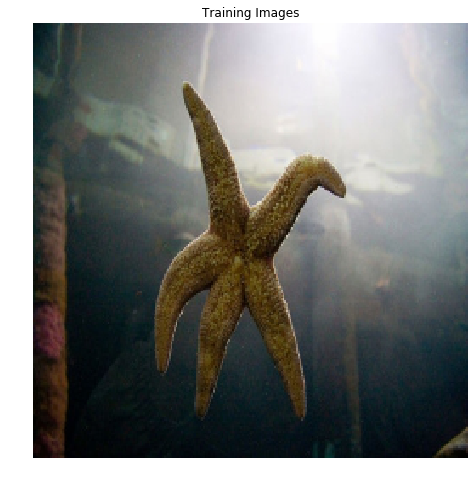

In [7]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(inputs[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

First, a benchmark with OpenCV

In [10]:
# import cv2

# img = inputs[0].numpy()
# sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=1)

In [ ]:
# import matplotlib.pyplot as plt

# plt.imshow(sobelx[0], cmap = 'gray')

In [8]:
from src.models.gradients import SobelX, SobelY

# sobel_x = SobelX(in_channels=1)
# sobel_y = SobelY(in_channels=1)
sobel_x = SobelX()
sobel_y = SobelY()

In [9]:
out = sobel_x(inputs)
out.shape

torch.Size([1, 1, 256, 256])

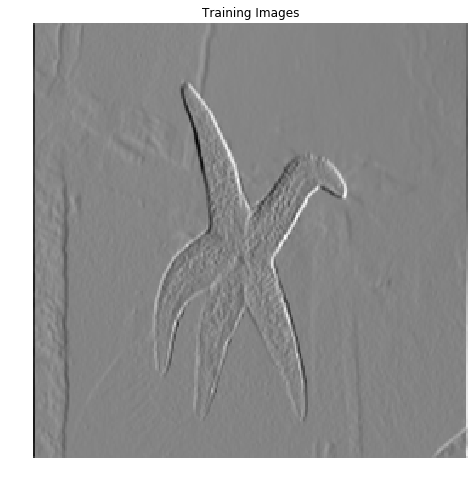

In [10]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(out[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Nice. Now for the HOG.

In [11]:
import torch

gx = sobel_x(inputs)
gy = sobel_y(inputs)

mag = torch.sqrt(gx**2 + gy**2)
ang = torch.atan2(gx, gy)

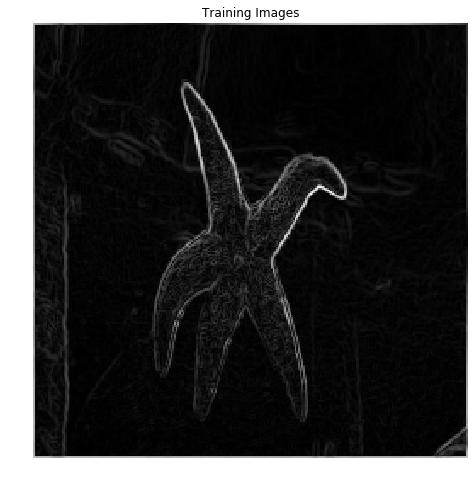

In [12]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(mag[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

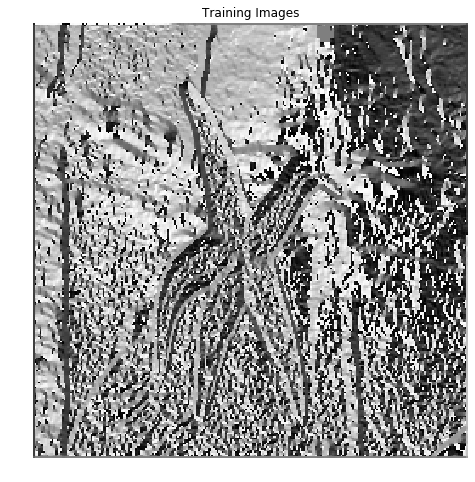

In [13]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(ang[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [14]:
ang.shape

torch.Size([1, 1, 256, 256])

In [15]:
ang

tensor([[[[-2.3484e+00,  3.1171e+00,  3.1190e+00,  ..., -9.4455e-02,
           -1.8006e-01, -8.5056e-01],
          [-1.5384e+00,  6.1680e-01,  5.4756e-01,  ..., -1.6664e+00,
           -1.7228e+00, -1.6104e+00],
          [-1.5700e+00,  1.4601e+00,  1.0427e+00,  ..., -1.9001e+00,
           -1.8076e+00, -1.6188e+00],
          ...,
          [-1.6243e+00,  2.5393e+00,  2.8055e+00,  ...,  2.7292e+00,
            2.4321e+00,  1.6680e+00],
          [-1.5898e+00,  2.1880e+00,  2.4669e+00,  ...,  2.2731e+00,
            2.4228e+00,  1.5915e+00],
          [-7.8810e-01,  2.4083e-02,  2.3838e-02,  ...,  1.0624e-02,
            1.3316e-03,  7.8184e-01]]]])

In [16]:
import math

grad_bins = (ang.abs() / math.pi * 8).floor().long()
grad_bins.shape

torch.Size([1, 1, 256, 256])

In [18]:
a = torch.tensor([[[[1,0],[2,1]]]])
a.shape

torch.Size([1, 1, 2, 2])

In [19]:
aux = torch.zeros((1, 3, 2, 2), dtype=torch.float, device=out.device)
aux.scatter_(1, a, 7)

tensor([[[[0., 7.],
          [0., 0.]],

         [[7., 0.],
          [0., 7.]],

         [[0., 0.],
          [7., 0.]]]])

In [20]:
n, c, h, w = out.shape

aux = torch.zeros((n, 9, h, w), dtype=torch.float, device=out.device)

In [21]:
aux.shape

torch.Size([1, 9, 256, 256])

In [22]:
grad_bins.max()

tensor(8)

In [23]:
scat = aux.scatter_(1, grad_bins, mag)
scat

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  3.7422,  3.3722,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000, 11.3994, 11.1875,  ..., 11.8124, 11.7804,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.5288,  0.3766,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 12.4729]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  3.4069],
          [ 0.0000,  0.0000,  

In [24]:
cell_pooling = torch.nn.AvgPool2d(8, stride=8, padding=0)

hog = cell_pooling(scat) * 8**2
print(hog.shape)
hog

torch.Size([1, 9, 32, 32])


tensor([[[[1.2424e+00, 5.9937e-01, 5.8092e-01,  ..., 5.4239e+01,
           4.5240e+01, 2.9145e+01],
          [3.1373e-01, 2.4200e+00, 1.4341e+00,  ..., 0.0000e+00,
           5.1742e-01, 0.0000e+00],
          [6.4342e-01, 1.1927e+00, 1.7538e-01,  ..., 1.5765e-01,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.9500e+00, 3.6910e+00, 8.0977e-02,  ..., 1.3300e+00,
           4.9977e-01, 2.0893e+00],
          [1.0730e+00, 1.1208e+01, 0.0000e+00,  ..., 4.2276e-01,
           6.0243e+00, 7.0696e+00],
          [8.0663e+01, 8.4306e+01, 9.0426e+01,  ..., 8.3420e+01,
           8.5714e+01, 8.1667e+01]],

         [[4.6066e+00, 3.2300e-01, 1.1528e+00,  ..., 0.0000e+00,
           0.0000e+00, 1.2251e-01],
          [3.0620e+00, 3.1158e+00, 2.6658e+00,  ..., 3.1568e-01,
           1.6044e+00, 0.0000e+00],
          [2.1821e+00, 4.7869e+00, 1.1607e+00,  ..., 2.4087e+00,
           8.4227e-01, 0.0000e+00],
          ...,
          [5.0362e+00, 1.0845e+01, 5.6558e-02,  ..., 6.7066

In [25]:
hog.flatten()

tensor([1.2424, 0.5994, 0.5809,  ..., 0.0000, 0.0000, 0.0000])

In [26]:
hog.flatten().shape

torch.Size([9216])

In [27]:
from src.models.hog import HOG

net = HOG()

In [28]:
net(inputs)

tensor([1.2424, 0.5994, 0.5809,  ..., 0.0000, 0.0000, 0.0000])

In [30]:
net(inputs).shape

torch.Size([9216])

In [ ]:
for i, data in enumerate(data_loader, 0): # iterate batches
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    print(inputs)
#     outputs = net(inputs)